In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests as r
import openpyxl
from io import BytesIO
import datetime
import mpl_axes_aligner

In [53]:
sheet_id = '1mrbBkhl6TDZNPUTZkHOaRw6MqLU5VHyURoRnQNqZ7-M'
url = "https://docs.google.com/spreadsheets/export?exportFormat=xlsx&id=" + sheet_id

file = r.get(url)
data = BytesIO(file.content)
xlsx = pd.ExcelFile(data)

In [55]:
flow_data = {}
meta_data = {}

for name in xlsx.sheet_names:
    if name == 'Summary': 
        continue
    if '!' in name: 
        continue
    flow_data[name] = pd.read_excel(data, sheet_name = name, usecols='A:F', skiprows=12)
    meta_data[name] = pd.read_excel(data, sheet_name = name, nrows = 12, header=None)

In [4]:
class Measurement(): 
    
    table_schema = {'station': [0, 3], 
                'coordinates': [0, 6], 
                'site_code': [0, 13],
                'date': [2, 2], 
                'start_time': [2, 4],
                'end_time': [3, 4],
                'timezone': [2, 5], 
                'meter_type': [2, 13],
                'crew': [4, 1, [4, 2]]}
    
    def __init__(self, name):
        self.name = name
        
        
        self.flow_data = flow_data[name].dropna()
        self.discharge = self.flow_data['Dis-charge, ft3/s'].sum()
        self.area = self.flow_data['Area, ft2'].sum()
        self.average_velocity = self.discharge / self.area
        self.max_observed_depth = self.flow_data['Depth'].max()
        
        
        self.meta_table = meta_data[name]
        for variable, coord in table_schema.items(): 
            self.__dict__[variable] = self.meta_table.iloc[coord[0], coord[1]]
            
            if pd.isnull(self.__dict__[variable]) and coord[2:]: 
                #If there is a backup location listed, use that instead. 
                self.__dict__[variable] = self.meta_table.iloc[coord[2][0], coord[2][1]]
        if pd.isnull(self.site_code): 
            self.site_code = self.name.split(' ')[0]
        print(name)
        self.crew = self.crew.split(', ')
        
        
list_measurements = [Measurement(name) for name in flow_data.keys()]
list_dates = sorted(list(set([measurement.date for measurement in list_measurements])))
sites = list(set([measurement.site_code for measurement in list_measurements]))

STUP 11-17-2023 0.35 cfs
STUP 10-27-2023 0.36cfs
Unnamed 11-3-2023 0.2cfs
Unnamed 10-27-2023 0.21cfs
STWB 11-17-2023 0.47 cfs
STWB 11-3-2023 0.48cfs
STWB 10-27-2023 0.71cfs


In [5]:
def plotmany(location, dates, variables, l_axis=False, r_axis=False): 
    fig, ax1 = plt.subplots()
    
    l_axis = l_axis or variables[0]
    variables.remove(l_axis)
    variables.insert(0, l_axis)
    
    if len(variables) > 1: 
        r_axis = r_axis or variables[1]
        variables.remove(r_axis)
        variables.insert(1, r_axis)
    
    data = [measure for measure in list_measurements if (measure.date in dates and measure.site_code == location)]
    data = sorted(data, key = lambda x: x.date, reverse=True)
    
    alpha = 1
    for measure in data: 
        measure.alpha = alpha
        alpha = alpha - 1/(len(dates))
    
    ylabels = {'Depth': 'DEPTH, IN FEET', 'Velocity': 'VELOCITY, IN FT/S', 'Discharge': 'DISCHARGE, CFS'}
    col_names = {'Depth': 'Depth', 'Velocity': 'V', 'Discharge': 'Dis-charge, ft3/s'}
    color_dict = {'Depth': 'k', 'Velocity': 'C0', 'Discharge': 'C1'}
    xlabel = 'DISTANCE ALONG SECTION, IN FEET'
    
    color = color_dict[l_axis]
    ax1.set_ylabel(ylabels[l_axis], color=color)
    ax1.set_xlabel(xlabel)
    ax1.tick_params(axis='y', labelcolor=color)
    
    for measure in data: 
        ax1.plot(measure.flow_data[col_names[variables[0]]], alpha=measure.alpha, color=color)
        
    if r_axis: 
        ax2 = ax1.twinx()
        color = color_dict[r_axis]
        ax2.set_ylabel(ylabels[r_axis], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        for measure in data: 
            ax2.plot(measure.flow_data[col_names[variables[1]]], alpha=measure.alpha, color=color)
        mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
    
    if len(variables) == 3: 
        ax3 = ax1.twinx()
        color = color_dict[variables[2]]
        ax3.spines.right.set_position(('axes', 1.2))
        ax3.tick_params(axis='y', labelcolor=color)
        ax3.set_ylabel(ylabels[variables[2]], color=color)


        for measure in data:
            ax3.plot(measure.flow_data[col_names[variables[2]]], alpha=measure.alpha, color=color)
        mpl_axes_aligner.align.yaxes(ax1, 0, ax3, 0, 0.1)
    
    
    
    
    fig.tight_layout()
    plt.show()
    

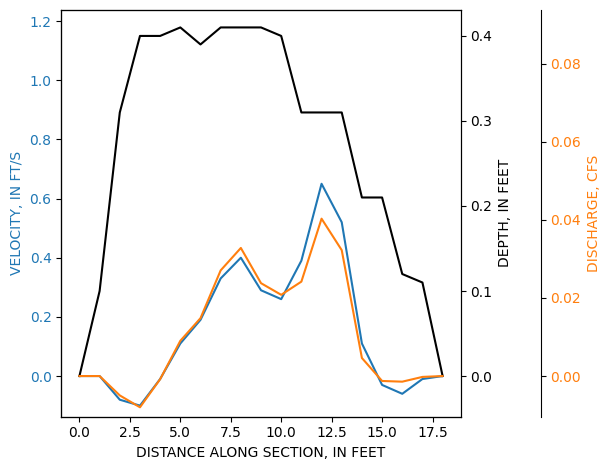

In [6]:
plotmany('Unnamed', [datetime.datetime(2023, 11, 17, 0, 0), datetime.datetime(2023, 10, 27, 0, 0)], ['Velocity', 'Depth', 'Discharge'])

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



def f(location, dates, variables): 
    return plotmany(location, dates, list(variables))

interact(f, 
         location = sites,
         dates = widgets.SelectMultiple(
                options = [(date.strftime('%d/%m/%Y'), date) for date in list_dates], 
                values = [list_dates[0]], 
                description = 'Dates'),
         variables = widgets.SelectMultiple(
                options = ['Depth', 'Velocity', 'Discharge'], 
                value = ['Depth'],
                description = 'Variables'))

interactive(children=(Dropdown(description='location', options=('Unnamed', 'STWB', 'STUP'), value='Unnamed'), …

<function __main__.f(location, dates, variables)>

In [ ]:
https://wr.slocountywater.org/export/file/?site_id=29&
    site=5952eafd-17d9-4cb6-a6dd-c949a99525f0&device_id=1&device=1c308219-4b72-4307-a5c0-76ed02cdba41&
    mode=&hours=&data_start=2024-01-01%2000:00:00&data_end=2024-09-09%2023:59:59&
                    tz=US%2FPacific&format_datetime=%25Y-%25m-%25d+%25H%3A%25i%3A%25S&mime=txt&delimiter=comma

In [50]:
import io


url_base = 'https://wr.slocountywater.org/export/file/'

args = {'site_id': '29', 
        'site' : '5952eafd-17d9-4cb6-a6dd-c949a99525f0', 
        'device_id': '1',
        'device': '1c308219-4b72-4307-a5c0-76ed02cdba41',
        'mode' : '',
        'hours' : '',
        'data_start' : datetime.datetime(2024, 9, 1, 0, 0).strftime('%Y-%m-%d %H:%M:%S'),
        'data_end' : datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'tz' : 'US%2FPacific',
        'format_datetime' : '%25Y-%25m-%25d+%25H%3A%25i%3A%25S',
        'mime' : 'txt',
        'delimiter' : 'comma'}

url = url_base + '?' + '&'.join(['='.join([key, value]) for key, value in args.items()])

response = r.get(url)


csv_data = io.StringIO(response.text)
df = pd.read_csv(csv_data)

In [51]:
df

,Reading,Receive,Value,Unit,Data Quality
0,2024-09-09 09:27:13,2024-09-09 09:27:23,170.93,ft,A
1,2024-09-09 09:12:13,2024-09-09 09:12:23,170.93,ft,A
2,2024-09-09 08:57:13,2024-09-09 08:57:23,170.93,ft,A
3,2024-09-09 08:42:13,2024-09-09 08:42:23,170.93,ft,A
4,2024-09-09 08:27:13,2024-09-09 08:27:23,170.93,ft,A
...,...,...,...,...,...
801,2024-09-01 01:12:13,2024-09-01 01:12:23,170.95,ft,A
802,2024-09-01 00:57:13,2024-09-01 00:57:23,170.95,ft,A
803,2024-09-01 00:42:13,2024-09-01 00:42:23,170.95,ft,A
804,2024-09-01 00:27:13,2024-09-01 00:27:23,170.95,ft,A
